In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import statsmodels.graphics.tsaplots as sgt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [89]:
train = pd.read_csv('C:/Users/MARIA PAULA/Downloads/EAFIT/Proyecto de Grado/Programacion/Dataset_definitivos/Train.csv')
val = pd.read_csv('C:/Users/MARIA PAULA/Downloads/EAFIT/Proyecto de Grado/Programacion/Dataset_definitivos/Val.csv')

In [90]:
# train['Fecha Trafico'] = pd.to_datetime(train['Fecha Trafico'])
# val['Fecha Trafico'] = pd.to_datetime(val['Fecha Trafico'])

In [91]:
train = train.drop(['timestamp','Fecha Trafico'], axis = 1)
val = val.drop(['timestamp','Fecha Trafico'], axis = 1)

In [92]:
train.columns

Index(['codigo comuna', 'corredor_enc', 'sentido_enc', 'f_pm_25',
       'Velocidad (Km/h)', 'Intensidad', 'Nº vehiculos long 1',
       'Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc',
       'f_pm_25_lag_24_h', 'f_pm_25_lag_48_h', 'f_pm_25_lag_72_h',
       'f_sma_7_pm_25', 'f_sd_7_pm_25', 'f_sum_7_pm_25', 'f_sma_14_pm_25',
       'f_sd_14_pm_25', 'f_sum_14_pm_25', 'f_sma_28_pm_25', 'f_sd_28_pm_25',
       'f_sum_28_pm_25', 'f_sma_72_pm_25', 'f_sd_72_pm_25', 'f_sum_72_pm_25',
       'f_calendar_day_of_month', 'f_calendar_day_of_week', 'f_calendar_month',
       'pm_25', 'label_horizon_1_hours', 'label_horizon_2_hours',
       'label_horizon_3_hours', 'label_horizon_4_hours',
       'label_horizon_5_hours', 'label_horizon_6_hours',
       'label_horizon_7_hours', 'label_horizon_8_hours',
       'label_horizon_9_hours', 'label_horizon_10_hours',
       'label_horizon_11_hours', 'label_horizon_12_hours',
       'label_horizon_13_hours', 'label_horizon_14_hours',
       'la

Al haber usado rezagos pierdo informacion en las primeras fechas donde no hay rezagos, por lo que recorto la info para no tomar nulos y poder entrenar 

In [93]:
def missing_values(df):
    Column_Names = df.columns

    Total_rows = df.shape[0]

    missing_values = df.isnull().sum()

    Percent_missing = (missing_values / Total_rows)*100
    
    result = pd.DataFrame({
        'Column_Name': Column_Names,
        'Missing_Values': missing_values.values,
        'Total_Rows': Total_rows,
        'Percent_Missing': Percent_missing.values
    })

    return result

In [94]:
nulos = missing_values(train)
nulos.sort_values(by ='Missing_Values', ascending = False)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
12,f_pm_25_lag_72_h,6912,84484,8.181431
11,f_pm_25_lag_48_h,4608,84484,5.454287
10,f_pm_25_lag_24_h,2304,84484,2.727144
14,f_sd_7_pm_25,1,84484,0.001184
17,f_sd_14_pm_25,1,84484,0.001184
...,...,...,...,...
95,label_horizon_67_hours,0,84484,0.000000
96,label_horizon_68_hours,0,84484,0.000000
97,label_horizon_69_hours,0,84484,0.000000
98,label_horizon_70_hours,0,84484,0.000000


In [95]:
train.dtypes

codigo comuna             float64
corredor_enc              float64
sentido_enc               float64
f_pm_25                   float64
Velocidad (Km/h)          float64
                           ...   
label_horizon_67_hours    float64
label_horizon_68_hours    float64
label_horizon_69_hours    float64
label_horizon_70_hours    float64
label_horizon_71_hours    float64
Length: 100, dtype: object

In [96]:
def plot_acf_pacf(series, lags=72, alpha=0.05):
    plt.rcParams["figure.figsize"] = 25, 15
    
    # Calcula el intervalo de confianza
    n = len(series)
    conf_interval = 1.96 / np.sqrt(n)  # Nivel de confianza al 95%

    fig, axes = plt.subplots(2, 1)

    # ACF con intervalo de confianza
    acf_plot = plot_acf(series, zero=False, lags=lags, ax=axes[0], alpha=alpha)
    axes[0].axhline(y=conf_interval, linestyle="--", color="red", label="Conf. Interval")
    axes[0].axhline(y=-conf_interval, linestyle="--", color="red")
    axes[0].set_title("ACF")
    axes[0].legend()

    # PACF con intervalo de confianza
    pacf_plot = plot_pacf(series, zero=False, lags=lags, ax=axes[1], alpha=alpha)
    axes[1].axhline(y=conf_interval, linestyle="--", color="red", label="Conf. Interval")
    axes[1].axhline(y=-conf_interval, linestyle="--", color="red")
    axes[1].set_title("PACF")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

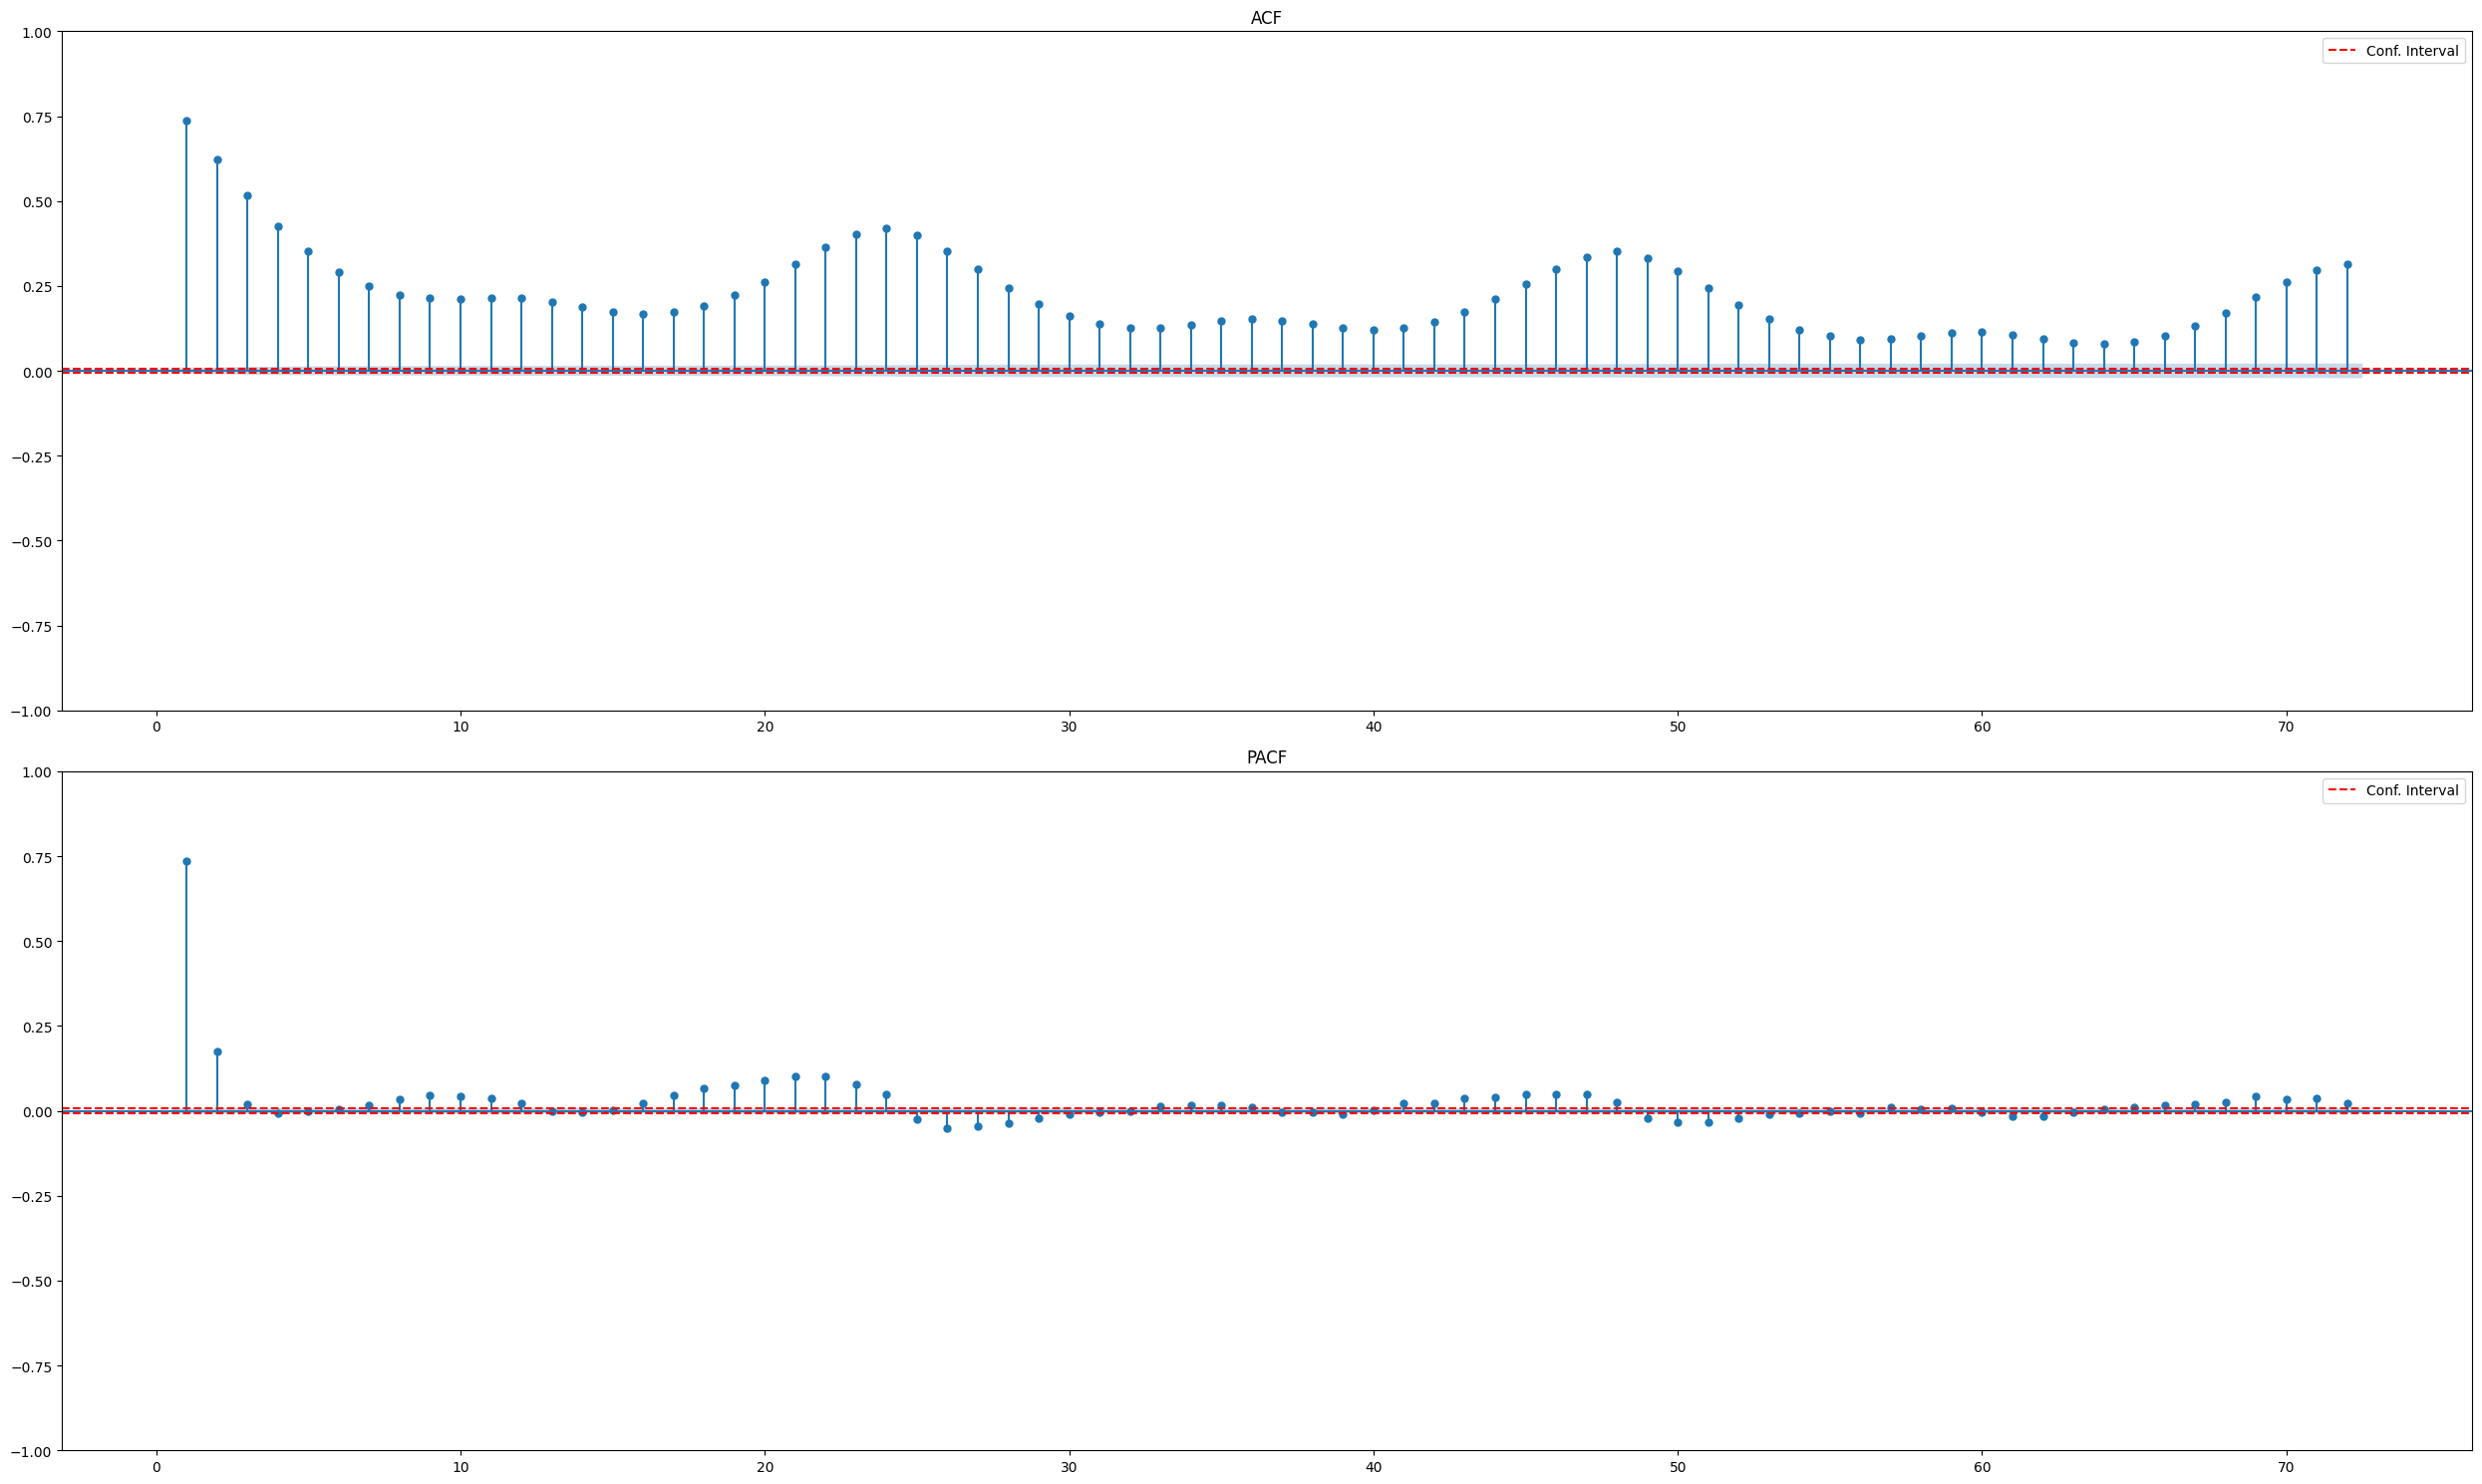

In [97]:
plot_acf_pacf(train['pm_25'])

* Gráfica de ACF:

Muestra una disminución gradual y persistente de la autocorrelación.
Esto podría indicar la presencia de componentes estacionales o tendencias a largo plazo en los datos.

* Gráfica de PACF:

Presenta una caída rápida después del primer lag y un comportamiento con valores muy pequeños para los lags subsiguientes, dentro del intervalo de confianza.

--------------------------------------------------
--------------------------------------------------
Los primeros valores (1 a 3 lags) parecen ser los más significativos, ya que se encuentran claramente fuera del intervalo de confianza en ambas gráficas.
A partir del lag 4 o 5, los valores de PACF están dentro del intervalo de confianza, lo que indica que no contribuyen significativamente a explicar la serie después de remover la correlación con los lags intermedios.

In [98]:
result = adfuller(train['pm_25'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF Statistic: -21.126839486813882
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430427465692802), '5%': np.float64(-2.861574238552925), '10%': np.float64(-2.56678822399577)}
The series is stationary.


# Entrenamiento del modelo

In [99]:
missing_values(train).sort_values(by = 'Missing_Values', ascending= True)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
0,codigo comuna,0,84484,0.000000
1,corredor_enc,0,84484,0.000000
2,sentido_enc,0,84484,0.000000
3,f_pm_25,0,84484,0.000000
4,Velocidad (Km/h),0,84484,0.000000
...,...,...,...,...
23,f_sd_72_pm_25,1,84484,0.001184
20,f_sd_28_pm_25,1,84484,0.001184
10,f_pm_25_lag_24_h,2304,84484,2.727144
11,f_pm_25_lag_48_h,4608,84484,5.454287


In [100]:
train = train.dropna()

In [101]:
missing_values(train)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
0,codigo comuna,0,77572,0.0
1,corredor_enc,0,77572,0.0
2,sentido_enc,0,77572,0.0
3,f_pm_25,0,77572,0.0
4,Velocidad (Km/h),0,77572,0.0
...,...,...,...,...
95,label_horizon_67_hours,0,77572,0.0
96,label_horizon_68_hours,0,77572,0.0
97,label_horizon_69_hours,0,77572,0.0
98,label_horizon_70_hours,0,77572,0.0


In [102]:
def separar_target(df): 
    X = df.drop(['pm_25'], axis=1)
    y = df['pm_25']
    return X, y

In [103]:
def filtrar_columnas(df):
    """
    Filtra el DataFrame eliminando:
    - Las columnas 'label_horizon_X_hours' donde X > 24.
    - Las columnas que empiezan con 'f_pm_25' y también son mayores a 24 horas.

    Parameters:
    df (pd.DataFrame): DataFrame original.

    Returns:
    pd.DataFrame: DataFrame filtrado.
    """
    # Filtrar columnas
    columnas_a_eliminar = [
        col for col in df.columns
        if (
            col.startswith('label_horizon') and int(col.split('_')[2]) > 24
        ) or (
            col.startswith('f_pm_25') and '_lag_' in col and int(col.split('_')[-2]) > 24
        )
    ]
    
    # Crear DataFrame filtrado
    df_filtrado = df.drop(columns=columnas_a_eliminar)
    return df_filtrado

In [104]:
def asegurarse_mismas_variables(df_train, df_val):
    """
    Asegura que el DataFrame de validación tenga las mismas variables que el de entrenamiento.
    
    Parameters:
    df_train (pd.DataFrame): DataFrame de entrenamiento.
    df_val (pd.DataFrame): DataFrame de validación.
    
    Returns:
    df_val (pd.DataFrame): DataFrame de validación con las mismas columnas que el de entrenamiento.
    """
    # Obtener las columnas del DataFrame de entrenamiento reducido
    columnas_comunes = df_train.columns
    
    # Filtrar las columnas para que solo contengan las mismas que en df_train
    df_val = df_val[columnas_comunes]
    
    return df_val


In [105]:
# Primero, eliminar las columnas altamente correlacionadas de df_train
train_reduced = filtrar_columnas(train)

# Luego, asegúrate de que val tenga las mismas columnas
val_reduced = asegurarse_mismas_variables(train_reduced, val)


In [106]:
X_train, y_train = separar_target(train_reduced)
X_val, y_val = separar_target(val_reduced)

In [107]:
def entrenamiento(model, X_train, y_train, X_test, y_test, cv = 3):
    """
    Entrena un modelo y lo evalúa en un conjunto de prueba.
    
    Parameters:
    model: El modelo de machine learning que se va a entrenar.
    X_train: DataFrame o array con las características del conjunto de entrenamiento.
    y_train: Serie o array con las etiquetas del conjunto de entrenamiento.
    X_test: DataFrame o array con las características del conjunto de prueba.
    y_test: Serie o array con las etiquetas del conjunto de prueba.
    
    Returns:
    model: El modelo entrenado.
    metrics: Diccionario con métricas de evaluación (MSE y R^2).
    """
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas de evaluación
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)

    # Validación cruzada con predicciones en cada pliegue
    y_cv_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    
    # Calcular métricas de evaluación para cada pliegue
    cv_rmse = root_mean_squared_error(y_train, y_cv_pred)  # RMSE para cada iteración
    cv_r2 = r2_score(y_train, y_cv_pred)  # R² para cada iteración
    cv_mae = mean_absolute_error(y_train, y_cv_pred)  # MAE para cada iteración
    
    # Imprimir resultados para cada iteración de validación cruzada
    print(f"\nResultados de Validación Cruzada para cada iteración:")
    for i in range(cv):
        print(f"Iteración {i+1}:")
        print(f"  RMSE: {cv_rmse:.4f}")
        print(f"  R^2: {cv_r2:.4f}")
        print(f"  MAE: {cv_mae:.4f}")
    
    # Promedio de las métricas de validación cruzada
    avg_cv_rmse = np.mean(cv_rmse)
    avg_cv_r2 = np.mean(cv_r2)
    avg_cv_mae = np.mean(cv_mae)
    
    # Imprimir resultados generales
    print(f"\nPromedio de Métricas de Validación Cruzada:")
    print(f"  Promedio RMSE: {avg_cv_rmse:.4f}")
    print(f"  Promedio R^2: {avg_cv_r2:.4f}")
    print(f"  Promedio MAE: {avg_cv_mae:.4f}")
    
    # Imprimir resultados para el conjunto de prueba
    print(f"\nEvaluación en el Conjunto de Prueba:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R^2 Score: {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {MAE:.4f}")
    
    # Devolver el modelo y las métricas
    metrics = {
        'RMSE': rmse,
        'R2': r2,
        'MAE': MAE,
        'CV_RMSE': avg_cv_rmse,
        'CV_R2': avg_cv_r2,
        'CV_MAE': avg_cv_mae
    }
    
    return model, metrics

In [108]:
def filtrar_columnas_y_eliminar(df, rezago):
    """
    Filtra el DataFrame eliminando:
    - Las columnas 'label_horizon_X_hours' donde X > 24.
    - Las columnas que empiezan con 'f_pm_25' y también son mayores a 24 horas.
    - Las columnas específicas: 'codigo comuna', 'corredor_enc' y 'sentido_enc'.
    
    Parameters:
    df (pd.DataFrame): DataFrame original.
    
    Returns:
    pd.DataFrame: DataFrame filtrado.
    """
    # Filtrar columnas con el patrón 'label_horizon_X_hours' donde X > 24
    columnas_a_eliminar = [
        col for col in df.columns
        if (
            col.startswith('label_horizon') and int(col.split('_')[2]) > rezago  # Extrae el número de horas
        ) or (
            col.startswith('f_pm_25') and '_lag_' in col and int(col.split('_')[-2]) > rezago  # Extrae el número de horas de 'f_pm_25_X_lag_Y'
        )
    ]
    
    # Agregar las columnas específicas que deben ser eliminadas
    columnas_a_eliminar.extend(['codigo comuna', 'corredor_enc', 'sentido_enc', 'Velocidad (Km/h)', 'Intensidad', 'Nº vehiculos long 1',
       'Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc'])

    # Crear DataFrame filtrado
    df_filtrado = df.drop(columns=columnas_a_eliminar, errors='ignore')
    
    return df_filtrado

In [109]:
# Primero, eliminar las columnas altamente correlacionadas de df_train
train_reduced_base = filtrar_columnas_y_eliminar(train, 7)

# Luego, asegúrate de que val tenga las mismas columnas
val_reduced_base = asegurarse_mismas_variables(train_reduced_base, val)

X_train_base, y_train_base = separar_target(train_reduced)
X_val_base, y_val_base = separar_target(val_reduced)

## Dataset Serie de tiempo sin vbles complementarias de mobilidad

In [125]:
# Modelos a entrenar
modelo_lr_base = LinearRegression()
modelo_rf_base = RandomForestRegressor(random_state=42)
modelo_xgb_base = XGBRegressor(random_state=42)

# Entrenar y evaluar Linear Regression
print("Entrenando Linear Regression:")
modelo_lr_entrenado_base, metrics_lr_base = entrenamiento(modelo_lr_base, X_train_base, y_train_base, X_val_base, y_val_base)

# Entrenar y evaluar Random Forest
print("\nEntrenando Random Forest:")
modelo_rf_entrenado_base, metrics_rf_base = entrenamiento(modelo_rf_base, X_train_base, y_train_base, X_val_base, y_val_base)

# Entrenar y evaluar XGBoost
print("\nEntrenando XGBoost:")
modelo_xgb_entrenado_base, metrics_xgb_base = entrenamiento(modelo_xgb_base, X_train_base, y_train_base, X_val_base, y_val_base)


Entrenando Linear Regression:

Resultados de Validación Cruzada para cada iteración:
Iteración 1:
  RMSE: 0.0761
  R^2: 0.9999
  MAE: 0.0512
Iteración 2:
  RMSE: 0.0761
  R^2: 0.9999
  MAE: 0.0512
Iteración 3:
  RMSE: 0.0761
  R^2: 0.9999
  MAE: 0.0512

Promedio de Métricas de Validación Cruzada:
  Promedio RMSE: 0.0761
  Promedio R^2: 0.9999
  Promedio MAE: 0.0512

Evaluación en el Conjunto de Prueba:
  RMSE: 0.0000
  R^2 Score: 1.0000
  Mean Absolute Error (MAE): 0.0000

Entrenando Random Forest:

Resultados de Validación Cruzada para cada iteración:
Iteración 1:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026
Iteración 2:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026
Iteración 3:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026

Promedio de Métricas de Validación Cruzada:
  Promedio RMSE: 0.0460
  Promedio R^2: 1.0000
  Promedio MAE: 0.0026

Evaluación en el Conjunto de Prueba:
  RMSE: 0.0016
  R^2 Score: 1.0000
  Mean Absolute Error (MAE): 0.0004

Entrenando XGBoost:

Resultados de Validación Cr

## Dataset Serie de tiempo con mobilidad

In [126]:
# Modelos a entrenar
modelo_lr = LinearRegression()
modelo_rf = RandomForestRegressor(random_state=42)
modelo_xgb = XGBRegressor(random_state=42)

# # Entrenar y evaluar Linear Regression
# print("Entrenando Linear Regression:")
# modelo_lr_entrenado, metrics_lr = entrenamiento(modelo_lr, X_train, y_train, X_val, y_val)

# Entrenar y evaluar Random Forest
print("\nEntrenando Random Forest:")
modelo_rf_entrenado, metrics_rf = entrenamiento(modelo_rf, X_train, y_train, X_val, y_val)

# Entrenar y evaluar XGBoost
print("\nEntrenando XGBoost:")
modelo_xgb_entrenado, metrics_xgb = entrenamiento(modelo_xgb, X_train, y_train, X_val, y_val)



Entrenando Random Forest:

Resultados de Validación Cruzada para cada iteración:
Iteración 1:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026
Iteración 2:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026
Iteración 3:
  RMSE: 0.0460
  R^2: 1.0000
  MAE: 0.0026

Promedio de Métricas de Validación Cruzada:
  Promedio RMSE: 0.0460
  Promedio R^2: 1.0000
  Promedio MAE: 0.0026

Evaluación en el Conjunto de Prueba:
  RMSE: 0.0016
  R^2 Score: 1.0000
  Mean Absolute Error (MAE): 0.0004

Entrenando XGBoost:

Resultados de Validación Cruzada para cada iteración:
Iteración 1:
  RMSE: 0.5377
  R^2: 0.9967
  MAE: 0.1121
Iteración 2:
  RMSE: 0.5377
  R^2: 0.9967
  MAE: 0.1121
Iteración 3:
  RMSE: 0.5377
  R^2: 0.9967
  MAE: 0.1121

Promedio de Métricas de Validación Cruzada:
  Promedio RMSE: 0.5377
  Promedio R^2: 0.9967
  Promedio MAE: 0.1121

Evaluación en el Conjunto de Prueba:
  RMSE: 0.1262
  R^2 Score: 0.9997
  Mean Absolute Error (MAE): 0.0407


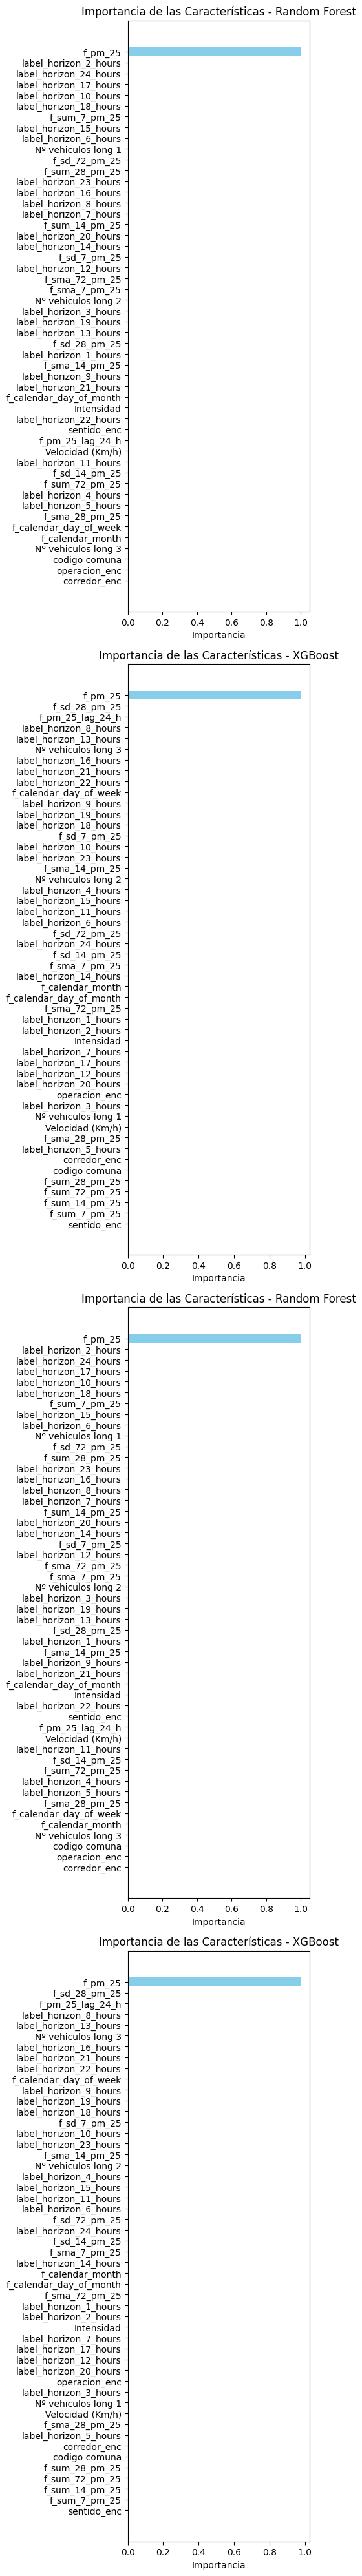

In [127]:
# Crear una lista de los modelos y sus atributos de importancia
modelos = [
    ('Random Forest', modelo_rf_entrenado, 'feature_importances_'),
    ('XGBoost', modelo_xgb_entrenado, 'feature_importances_'),
    ('Random Forest', modelo_rf_entrenado_base, 'feature_importances_'),
    ('XGBoost', modelo_xgb_entrenado_base, 'feature_importances_')
    #('Linear Regression', modelo_lr_entrenado, 'coef_')
]

# Crear una figura para los gráficos
fig, axes = plt.subplots(len(modelos), 1, figsize=(5, 10 * len(modelos)))

# Si solo hay un gráfico, asegúrate de que axes sea un iterable
if len(modelos) == 1:
    axes = [axes]

# Graficar las importancias para cada modelo
for i, (nombre_modelo, modelo, atributo) in enumerate(modelos):
    if atributo == 'feature_importances_':  # Para Random Forest y XGBoost
        importancias = getattr(modelo, atributo)
        importancia_df = pd.DataFrame({
            'Característica': X_train.columns,  # Asegúrate de que X_train tenga los nombres de las columnas
            'Importancia': importancias
        })
        importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
        
        # Graficar
        axes[i].barh(importancia_df['Característica'], importancia_df['Importancia'], color='skyblue')
        axes[i].set_xlabel('Importancia')
        axes[i].set_title(f'Importancia de las Características - {nombre_modelo}')
        axes[i].invert_yaxis()  # Para que la barra más importante esté en la parte superior
        
    elif atributo == 'coef_':  # Para Linear Regression
        importancias = getattr(modelo, atributo)
        importancia_df = pd.DataFrame({
            'Característica': X_train.columns,  # Asegúrate de que X_train tenga los nombres de las columnas
            'Importancia': importancias
        })
        importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
        
        # Graficar
        axes[i].barh(importancia_df['Característica'], importancia_df['Importancia'], color='lightgreen')
        axes[i].set_xlabel('Coeficiente')
        axes[i].set_title(f'Coeficientes de las Características - {nombre_modelo}')
        axes[i].invert_yaxis()  # Para que el coeficiente más importante esté en la parte superior

# Ajustar el diseño
plt.tight_layout()
plt.show()